In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima,arima
from statsmodels.tsa.stattools import adfuller
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [403]:
train = pd.read_csv("train.csv",parse_dates=['date'])
test = pd.read_csv("test.csv",parse_dates=['date'])
oil = pd.read_csv("oil.csv",parse_dates=['date'])
holiday = pd.read_csv("holidays_events.csv",parse_dates=['date'])
transactions = pd.read_csv("transactions.csv",parse_dates=['date'])
sample = pd.read_csv("sample_submission.csv")
stores = pd.read_csv("stores.csv")

In [404]:
family_group=[]
for i in range(33,66):
    family_group.append(train.iloc[i,3])

In [405]:
result=pd.concat([train,test])
result

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,NaN,1
28508,3029396,2017-08-31,9,PREPARED FOODS,NaN,0
28509,3029397,2017-08-31,9,PRODUCE,NaN,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


In [406]:

r1=pd.merge(result,stores,how="left",on=["store_nbr"])
r2=pd.merge(r1,transactions,how="left",on=["date","store_nbr"]).sort_values('store_nbr')
Data=pd.merge(r2,oil,how="left",on=["date"]).sort_values('date')
Data

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
1451962,612,2013-01-01,26,HOME CARE,0.0,0,Guayaquil,Guayas,D,10,NaN,NaN
1451963,613,2013-01-01,26,LADIESWEAR,0.0,0,Guayaquil,Guayas,D,10,NaN,NaN
1451965,614,2013-01-01,26,LAWN AND GARDEN,0.0,0,Guayaquil,Guayas,D,10,NaN,NaN
1451966,616,2013-01-01,26,"LIQUOR,WINE,BEER",0.0,0,Guayaquil,Guayas,D,10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2524726,3028943,2017-08-31,46,BREAD/BAKERY,NaN,14,Quito,Pichincha,A,14,NaN,47.26
2524727,3028942,2017-08-31,46,BOOKS,NaN,0,Quito,Pichincha,A,14,NaN,47.26
2524728,3028941,2017-08-31,46,BEVERAGES,NaN,41,Quito,Pichincha,A,14,NaN,47.26
2524716,3028953,2017-08-31,46,HOME AND KITCHEN I,NaN,0,Quito,Pichincha,A,14,NaN,47.26


In [407]:
Data.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales            28512
onpromotion          0
city                 0
state                0
type                 0
cluster              0
transactions    274296
dcoilwtico      935550
dtype: int64

In [408]:
Data.fillna(value={'dcoilwtico':0.0},inplace=True)
Data.fillna(value={'transactions':0.0},inplace=True)
Data.fillna(value={'sales':0.0},inplace=True)

In [409]:
Data.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type            0
cluster         0
transactions    0
dcoilwtico      0
dtype: int64

In [410]:
Data.head(10)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,0.0,0.0
1451962,612,2013-01-01,26,HOME CARE,0.0,0,Guayaquil,Guayas,D,10,0.0,0.0
1451963,613,2013-01-01,26,LADIESWEAR,0.0,0,Guayaquil,Guayas,D,10,0.0,0.0
1451965,614,2013-01-01,26,LAWN AND GARDEN,0.0,0,Guayaquil,Guayas,D,10,0.0,0.0
1451966,616,2013-01-01,26,"LIQUOR,WINE,BEER",0.0,0,Guayaquil,Guayas,D,10,0.0,0.0
1451967,617,2013-01-01,26,MAGAZINES,0.0,0,Guayaquil,Guayas,D,10,0.0,0.0
1451968,618,2013-01-01,26,MEATS,0.0,0,Guayaquil,Guayas,D,10,0.0,0.0
1451961,611,2013-01-01,26,HOME APPLIANCES,0.0,0,Guayaquil,Guayas,D,10,0.0,0.0
1451969,619,2013-01-01,26,PERSONAL CARE,0.0,0,Guayaquil,Guayas,D,10,0.0,0.0
1451971,621,2013-01-01,26,PLAYERS AND ELECTRONICS,0.0,0,Guayaquil,Guayas,D,10,0.0,0.0


In [411]:
Data.set_index("store_nbr",inplace=True)

In [412]:
store={}
store_family={}
family_group

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [413]:
for i in range(1,55):
    store[i]=Data.loc[i]
    store[i].set_index("family",inplace=True)
    for j in range(0,33):
        store_family[i,j]=store[i].loc[family_group[j]]

In [414]:
store_family[1,0].head()

,id,date,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico
family,,,,,,,,,,
AUTOMOTIVE,0,2013-01-01,0.0,0,Quito,Pichincha,D,13,0.0,0.00
AUTOMOTIVE,1782,2013-01-02,2.0,0,Quito,Pichincha,D,13,2111.0,93.14
AUTOMOTIVE,3564,2013-01-03,3.0,0,Quito,Pichincha,D,13,1833.0,92.97
AUTOMOTIVE,5346,2013-01-04,3.0,0,Quito,Pichincha,D,13,1863.0,93.12
AUTOMOTIVE,7128,2013-01-05,5.0,0,Quito,Pichincha,D,13,1509.0,0.00


In [415]:
store_family[1,0].set_index("date",inplace=True)

In [416]:

df=store_family[1,0]

<AxesSubplot:xlabel='date'>

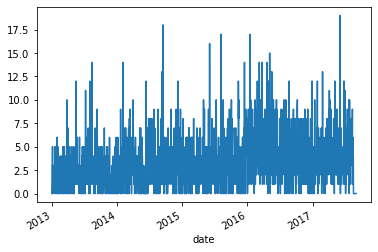

In [417]:
df["sales"].plot()

In [418]:
df.sort_values('date')

,id,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico
date,,,,,,,,,
2013-01-01,0,0.0,0,Quito,Pichincha,D,13,0.0,0.00
2013-01-02,1782,2.0,0,Quito,Pichincha,D,13,2111.0,93.14
2013-01-03,3564,3.0,0,Quito,Pichincha,D,13,1833.0,92.97
2013-01-04,5346,3.0,0,Quito,Pichincha,D,13,1863.0,93.12
2013-01-05,7128,5.0,0,Quito,Pichincha,D,13,1509.0,0.00
...,...,...,...,...,...,...,...,...,...
2017-08-27,3020490,0.0,0,Quito,Pichincha,D,13,0.0,0.00
2017-08-28,3022272,0.0,0,Quito,Pichincha,D,13,0.0,46.40
2017-08-29,3024054,0.0,0,Quito,Pichincha,D,13,0.0,46.46


In [419]:
def stationarity(data):
    rolling_mean=data.rolling(window=12).mean()
    rolling_std=data.rolling(window=12).std()
    plt.figure(figsize=(20,10))
    actual=plt.plot(data, color='red', label='Actual')
    mean_6=plt.plot(rolling_mean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(data, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[1]<=0.05:
        print("strong evidence against the null hypothesis,reject the null hypothesis.Data has no roots.it is stationary")
    else:
        print("weak evidence against the null hypothesis,time series has a unit root,indicating it is non stationary")

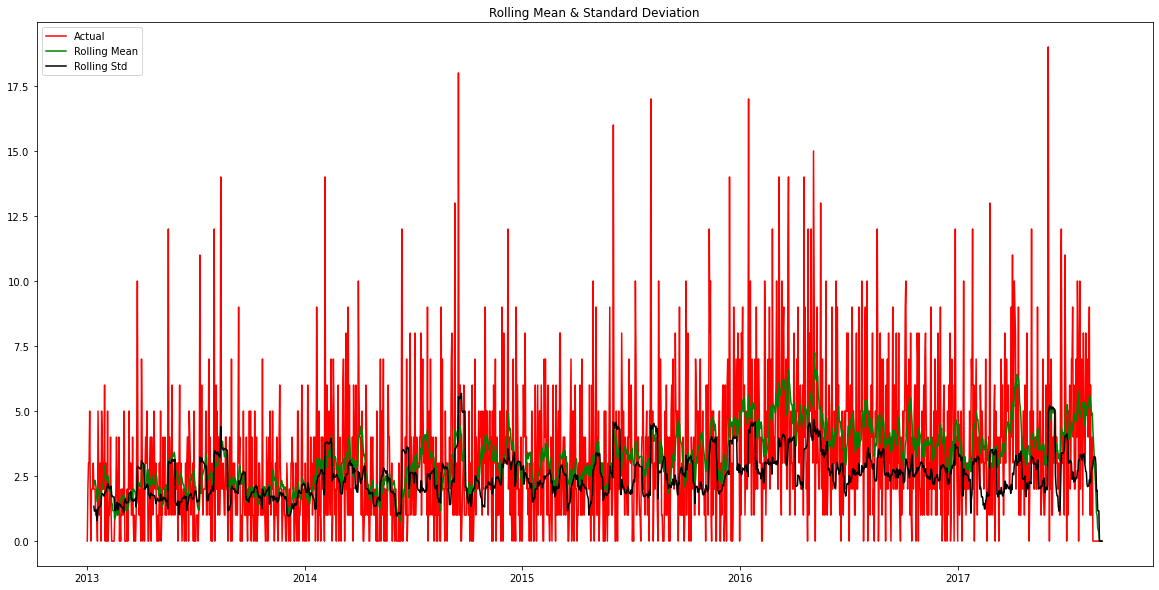

Dickey-Fuller Test: 
Test Statistic            -4.227552
p-value                    0.000592
Lags Used                 23.000000
No. of Obs              1676.000000
Critical Value (1%)       -3.434258
Critical Value (5%)       -2.863266
Critical Value (10%)      -2.567689
dtype: float64
strong evidence against the null hypothesis,reject the null hypothesis.Data has no roots.it is stationary


In [420]:
stationarity(df['sales'])

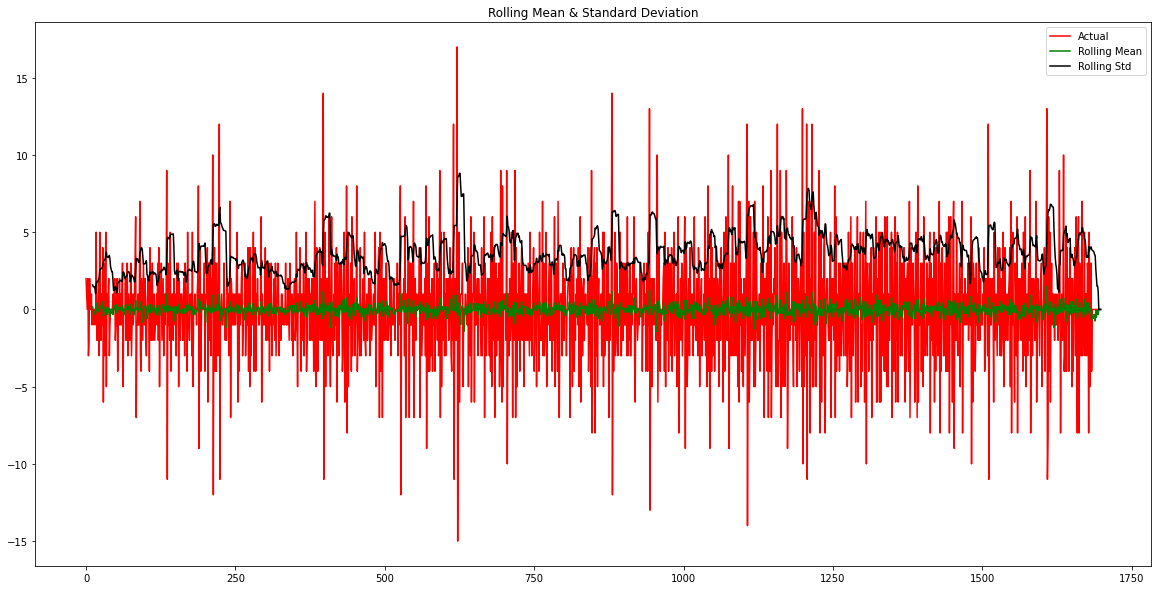

Dickey-Fuller Test: 
Test Statistic         -1.264104e+01
p-value                 1.434769e-23
Lags Used               2.500000e+01
No. of Obs              1.673000e+03
Critical Value (1%)    -3.434265e+00
Critical Value (5%)    -2.863269e+00
Critical Value (10%)   -2.567691e+00
dtype: float64
strong evidence against the null hypothesis,reject the null hypothesis.Data has no roots.it is stationary


In [421]:
diffdata=np.diff(df['sales'])
diff_data=pd.DataFrame(diffdata,columns=['sales'])
diff_data=diff_data.dropna()
stationarity(diff_data)

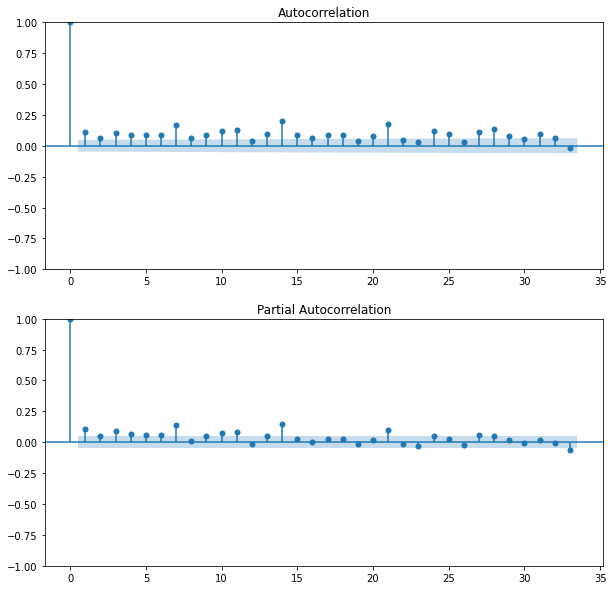

In [422]:
fig = plt.figure(figsize=(10,10))
axis1 = fig.add_subplot(211)
fig = plot_acf(df['sales'],ax=axis1)
axis2 = fig.add_subplot(212)
fig = plot_pacf(df['sales'],ax=axis2)

In [423]:
df.corr(method='pearson')

,id,sales,onpromotion,cluster,transactions,dcoilwtico
id,1.000000,0.256888,0.076966,NaN,-0.055098,-0.390965
sales,0.256888,1.000000,0.049251,NaN,0.290961,0.019603
onpromotion,0.076966,0.049251,1.000000,NaN,0.023052,-0.020652
cluster,NaN,NaN,NaN,NaN,NaN,NaN
transactions,-0.055098,0.290961,0.023052,NaN,1.000000,0.611883
dcoilwtico,-0.390965,0.019603,-0.020652,NaN,0.611883,1.000000


In [424]:
df.corr(method='kendall')

,id,sales,onpromotion,cluster,transactions,dcoilwtico
id,1.000000,0.191225,0.062861,NaN,-0.040559,-0.247105
sales,0.191225,1.000000,0.063609,NaN,0.165772,0.015499
onpromotion,0.062861,0.063609,1.000000,NaN,0.005416,-0.009749
cluster,NaN,NaN,NaN,1.0,NaN,NaN
transactions,-0.040559,0.165772,0.005416,NaN,1.000000,0.416684
dcoilwtico,-0.247105,0.015499,-0.009749,NaN,0.416684,1.000000


In [425]:
df.corr(method='spearman')

,id,sales,onpromotion,cluster,transactions,dcoilwtico
id,1.000000,0.270424,0.076966,NaN,-0.060380,-0.359135
sales,0.270424,1.000000,0.073515,NaN,0.232186,0.026442
onpromotion,0.076966,0.073515,1.000000,NaN,0.006625,-0.011524
cluster,NaN,NaN,NaN,NaN,NaN,NaN
transactions,-0.060380,0.232186,0.006625,NaN,1.000000,0.599455
dcoilwtico,-0.359135,0.026442,-0.011524,NaN,0.599455,1.000000


In [426]:
def optimize_SARIMA(parameters_list, d, D, s, endog):
    results = []
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog=endog,exog=df[['onpromotion','transactions']], order=(param[0], d, param[1]),k_exog=2, seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [427]:
p = range(0, 4, 1)
q = range(0, 4, 1)
P = range(0, 4, 1)
Q = range(0, 4, 1)
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [428]:
D=arima.nsdiffs(df['sales'][:-16],12)
d=arima.ndiffs(df['sales'][:-16])
result_df = optimize_SARIMA(parameters_list, d, D, 12, df['sales'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(0, 1, 0, 2)",7976.631183
1,"(0, 1, 0, 0)",7976.940853
2,"(0, 1, 0, 1)",7977.231260
3,"(0, 0, 2, 0)",9101.221841
4,"(0, 0, 0, 2)",9101.377021
5,"(0, 0, 3, 0)",9102.973778
6,"(0, 0, 1, 2)",9103.220494
7,"(0, 0, 2, 1)",9103.285434
8,"(0, 0, 1, 0)",9103.819859
9,"(0, 0, 0, 1)",9104.328420


In [431]:
model = SARIMAX(endog=train_data,order=(0, 1, 1), seasonal_order=(0, 1, 2, 12),exog=df[['onpromotion','transactions']]).fit()
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   sales   No. Observations:                 1700
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -3845.607
Date:                                 Sat, 08 Jan 2022   AIC                           7703.214
Time:                                         16:56:09   BIC                           7735.798
Sample:                                              0   HQIC                          7715.281
                                                - 1700                                         
Covariance Type:                                   opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
onpromotion      1.7766      0.736      2.415      0.016       0.335  

In [434]:
data=df['sales']
train_data=data.copy()
train_data.loc[-62:]=np.nan
test_data=df['sales'].iloc[-62:-16]
test_exog=df[['onpromotion','transactions']].iloc[-60:]

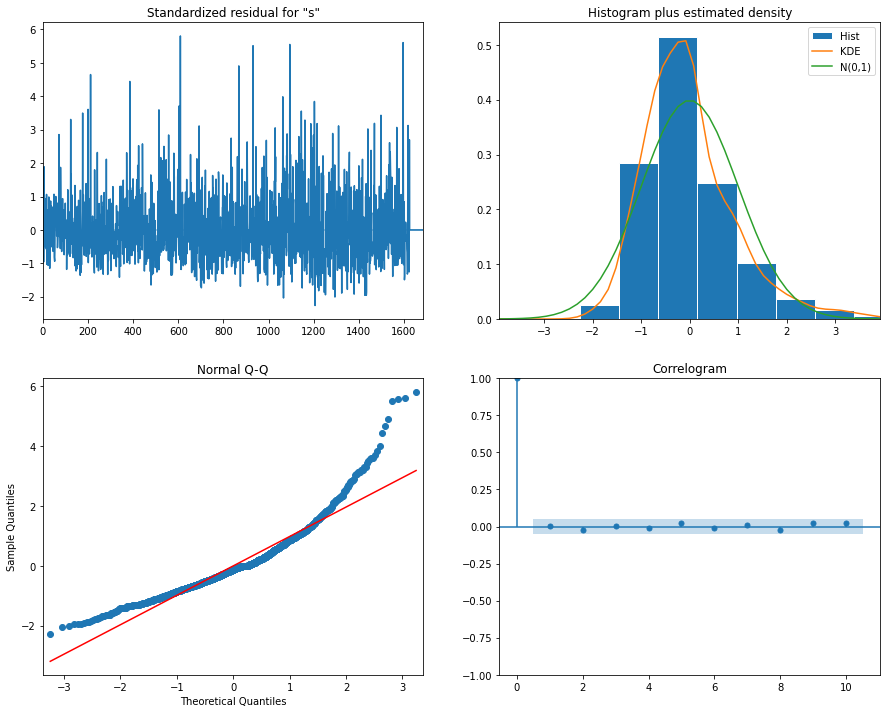

In [435]:
model.plot_diagnostics(figsize=(15,12));

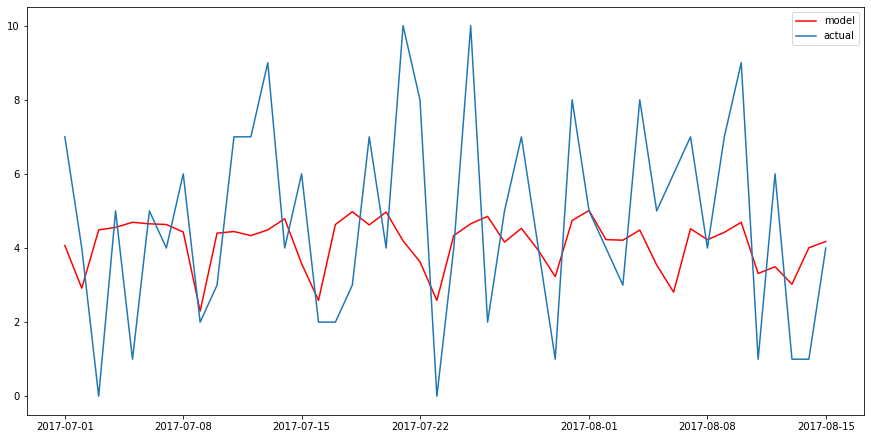

date
2017-07-01    4.067240
2017-07-02    2.916055
2017-07-03    4.487910
2017-07-04    4.556464
2017-07-05    4.694460
2017-07-06    4.652591
2017-07-07    4.634251
2017-07-08    4.433010
2017-07-09    2.298219
2017-07-10    4.400134
2017-07-11    4.444893
2017-07-12    4.334741
2017-07-13    4.487671
2017-07-14    4.790670
2017-07-15    3.580320
2017-07-16    2.587152
2017-07-17    4.634336
2017-07-18    4.978984
2017-07-19    4.623107
2017-07-20    4.971324
2017-07-21    4.194748
2017-07-22    3.628352
2017-07-23    2.585182
2017-07-24    4.337661
2017-07-25    4.653141
2017-07-26    4.854498
2017-07-27    4.159624
2017-07-28    4.529930
2017-07-29    3.937290
2017-07-30    3.227751
2017-07-31    4.743564
2017-08-01    5.013371
2017-08-02    4.226630
2017-08-03    4.210560
2017-08-04    4.484399
2017-08-05    3.541876
2017-08-06    2.808977
2017-08-07    4.520464
2017-08-08    4.224904
2017-08-09    4.422415
2017-08-10    4.693745
2017-08-11    3.313359
2017-08-12    3.494740
2017-0

In [460]:
from datetime import datetime
start=datetime(2017,7,1)
end=datetime(2017,8,15)
predict=model.predict(start=start ,end=end,exog=test_exog)
plt.figure(figsize=(15, 7.5))
plt.plot(predict, color='r', label='model')
#plt.axvspan(df.index[0],forecast.index[0], alpha=0.5, color='lightgrey')
plt.plot(test_data, label='actual')
plt.legend()
plt.show()
predict

In [437]:
from sklearn.metrics import mean_squared_error
error=np.sqrt(mean_squared_error(test_data,forecast))
error

2.5882167117026698

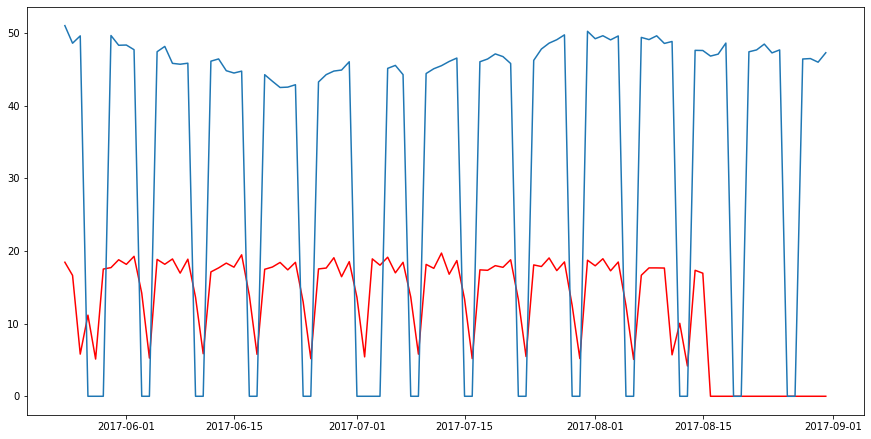

In [443]:
plt.figure(figsize=(15, 7.5))
plt.plot(df['transactions'][-100:]/100,color='r',label='transactions')
plt.plot(df['dcoilwtico'][-100:],label='dcoilwtico')

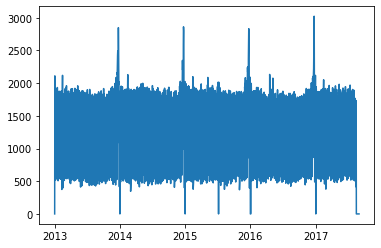

In [445]:
plt.plot(df['transactions'])

In [447]:
data1=df['transactions']
train_transactions_data=data1.copy()
train_transactions_data.loc[-16:]=np.nan
test_transactions_exog=df['dcoilwtico'].iloc[-16:]

In [456]:
model1=SARIMAX(endog=train_transactions_data,order=(0, 0, 1), seasonal_order=(0, 0, 1, 12),exog=df['dcoilwtico']).fit()
print(model1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       transactions   No. Observations:                 1700
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood              -13166.801
Date:                            Sat, 08 Jan 2022   AIC                          26341.602
Time:                                    17:10:59   BIC                          26363.355
Sample:                                         0   HQIC                         26349.655
                                           - 1700                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dcoilwtico    14.9841      0.357     41.954      0.000      14.284      15.684
ma.L1          0.5582      0.022   

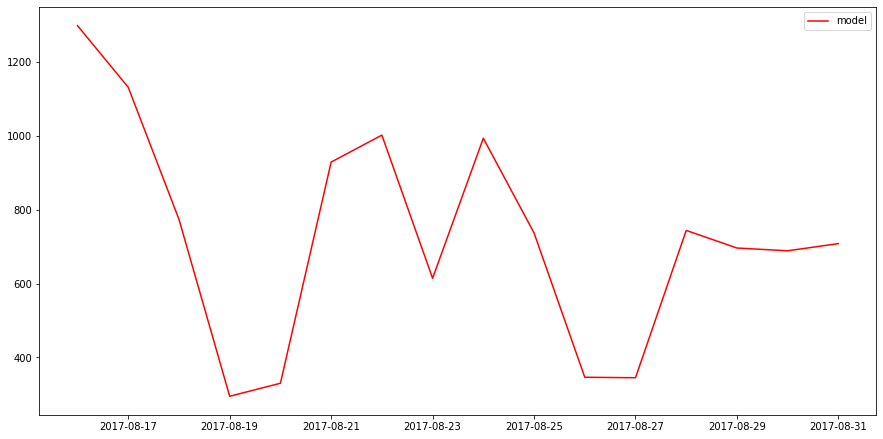

date
2017-08-16    1298.174252
2017-08-17    1131.322733
2017-08-18     773.949720
2017-08-19     294.838060
2017-08-20     330.055088
2017-08-21     928.754053
2017-08-22    1001.861060
2017-08-23     614.299943
2017-08-24     993.401811
2017-08-25     737.038303
2017-08-26     346.300306
2017-08-27     345.033085
2017-08-28     743.791674
2017-08-29     696.162841
2017-08-30     688.670774
2017-08-31     708.150148
Name: predicted_mean, dtype: float64

In [457]:
start=datetime(2017,8,16)
end=datetime(2017,8,31)
forecast=model1.predict(start=start ,end=end,exog=test_transactions_exog)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.legend()
plt.show()
forecast

In [462]:
exog_predict=df[['onpromotion','transactions']][-16:]
exog_predict['transactions'][-16:]=forecast1

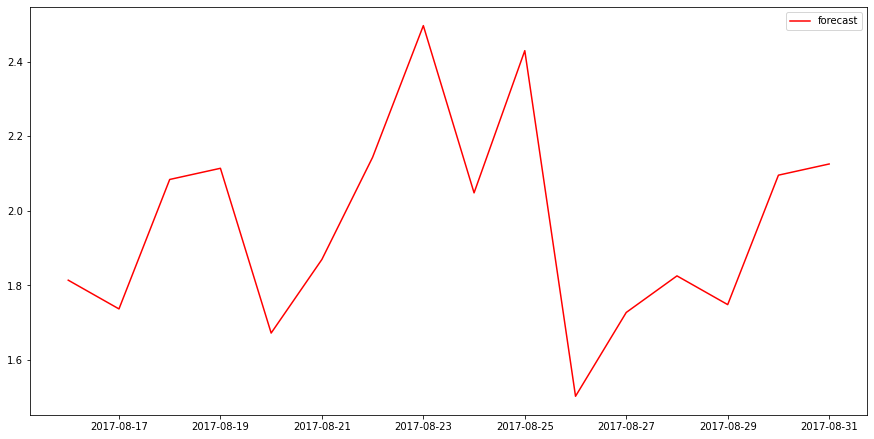

date
2017-08-16    1.814019
2017-08-17    1.736917
2017-08-18    2.084342
2017-08-19    2.114357
2017-08-20    1.672140
2017-08-21    1.869651
2017-08-22    2.143884
2017-08-23    2.497245
2017-08-24    2.048436
2017-08-25    2.430051
2017-08-26    1.502461
2017-08-27    1.727432
2017-08-28    1.825572
2017-08-29    1.748470
2017-08-30    2.095895
2017-08-31    2.125910
Name: predicted_mean, dtype: float64

In [463]:
from datetime import datetime
start=datetime(2017,8,16)
end=datetime(2017,8,31)
forecast=model.predict(start=start ,end=end,exog=exog_predict)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='forecast')
plt.legend()
plt.show()
forecast